In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as iplot
import cufflinks as cf
cf.go_offline()

In [2]:
### imported `Gaussian Naive Bayes` because of the continuous dataset.

In [3]:
### loading the diabetes dataset

df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


- ### If you really wanna deep dive into data then atleast you have to have some business understanding of the data.
- ### Suppose, for this `diabetes dataset`, if you know that in general doctor bases his prescription for medicines individually wrt to the features viz. Glucose, BloodPressure, etc. then you'll know instantly that Naive Bayes will be the best classfier pick for this dataset.
- ### Even if you do not have any buisness understandings, asking the right questions to your client is gonna suffice.

In [4]:
df.shape

(768, 9)

In [5]:
## Check for na vals

df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

No Null vals whatsoever!

In [6]:
### bird-eyw view of dataset

df.iplot(kind='hist', subplots=True, dimensions=(1000, 800))

# # dealing with Outliers: 

<AxesSubplot:>

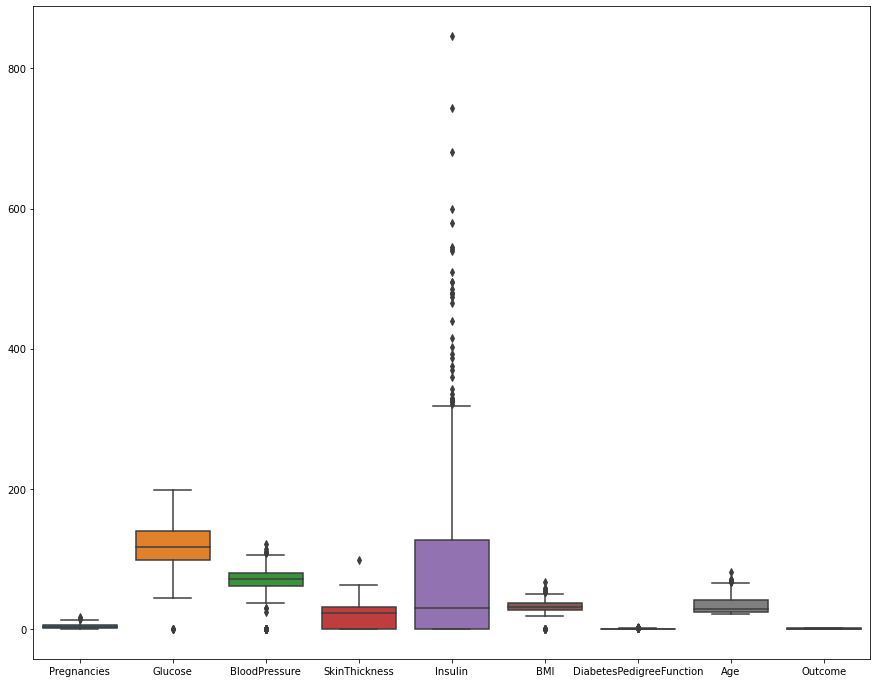

In [7]:
### Checking for outliers

plt.figure(figsize=(15, 12))
sns.boxplot(data=df)

In [8]:
def replace_outliers(df, skip_columns):
    """
    Replaces the outliers of the desired columns with NaN vals and skip the columns passed in 
    'skip-columns' argument.
    """
    def fences(df, col):
        q1 = np.nanpercentile(df, 25)
        q3 = np.nanpercentile(df, 75)
        iqr = q3 - q1
        lfence = q1 - 1.5*iqr
        ufence = q3 + 1.5*iqr
        
        return lfence, ufence
    
    for col in df.columns:
        if col in skip_columns:
            continue
            
        lf, uf = fences(df, col)
        
        # replace the outliers by np.NaN
        # ouliers below the lower fence
        df[col] = df[col].mask(df[col]<lf, np.NaN)
        
        # outliers above the upper fence
        df[col] = df[col].mask(df[col]>uf, np.NaN)

In [9]:
## Create a copy of the org dataset so that org dataset remains intact and no changes are reflected upon it

df1 = df.copy(deep=True)
df1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [10]:
### Replacing the outliers by Nan so that they could be dropped or imputed as per requirement

replace_outliers(df1, skip_columns=["Outcome"])

In [11]:
df1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72,35,0.0,33.6,0.627,50,1
1,1,85.0,66,29,0.0,26.6,0.351,31,0
2,8,NaN,64,0,0.0,23.3,0.672,32,1
3,1,89.0,66,23,94.0,28.1,0.167,21,0
4,0,137.0,40,35,NaN,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76,48,NaN,32.9,0.171,63,0
764,2,122.0,70,27,0.0,36.8,0.340,27,0
765,5,121.0,72,23,112.0,26.2,0.245,30,0
766,1,126.0,60,0,0.0,30.1,0.349,47,1


In [12]:
## now checking for the Nan vals

df1.isna().sum()

Pregnancies                   0
Glucose                     134
BloodPressure                 0
SkinThickness                 0
Insulin                     173
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

- ## Imputing the outliers (now NaN) by the median of respective feature

In [13]:
### Let's impute the outliers by median of their repsective columns

def impute_them_all(df, skip_columns):
    for col in df.columns:
        if col in skip_columns:
            continue
        df[col].mask(df[col].isna(), df[col].median(), inplace=True)

In [14]:
impute_them_all(df=df1, skip_columns=["Outcome"])

<AxesSubplot:>

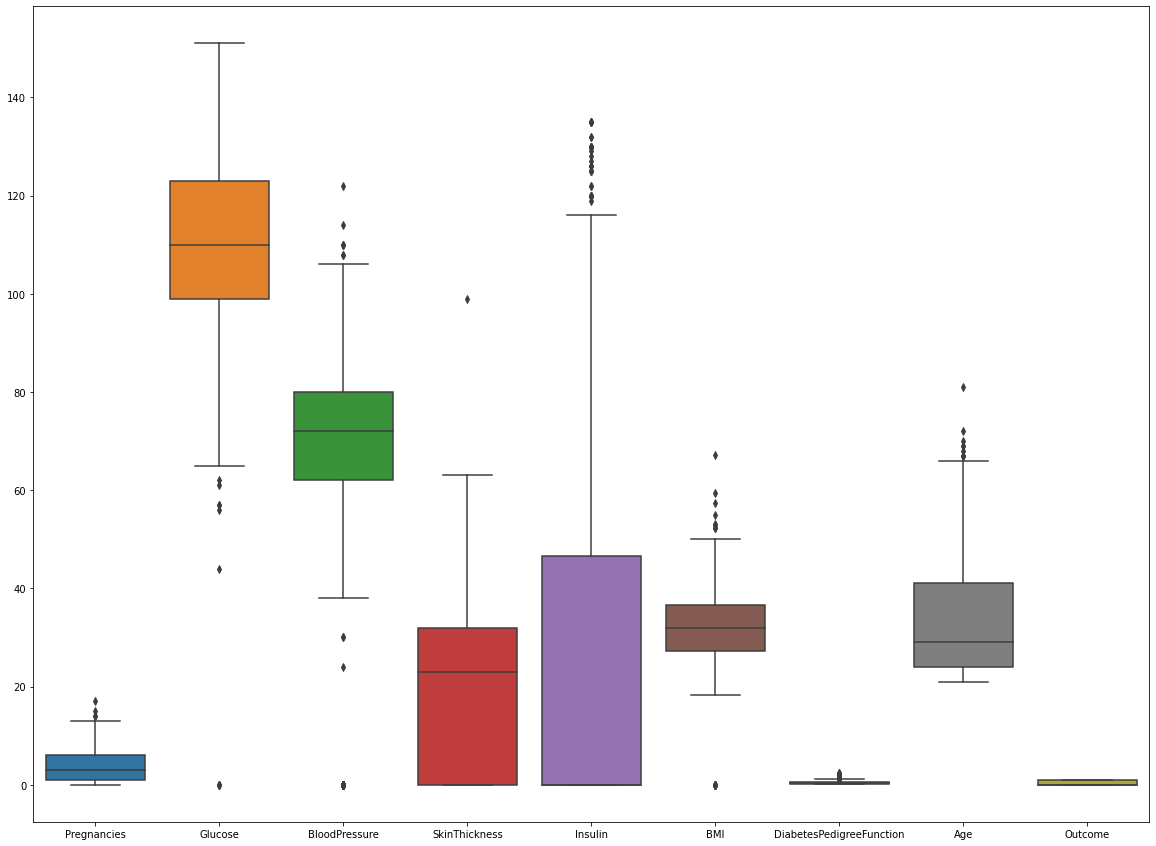

In [15]:
### Let's now check for the outliers

plt.figure(figsize=(20, 15))
sns.boxplot(data=df1)

### Comparitively way less ouliers than before!

- ## Dropping the outliers

In [16]:
df2 = df.copy(deep=True)
df2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [17]:
replace_outliers(df2, skip_columns=["Outcome"])

In [18]:
df2.isna().sum()

Pregnancies                   0
Glucose                     134
BloodPressure                 0
SkinThickness                 0
Insulin                     173
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [19]:
## Dropping the outliers (now NaN)

df2.dropna(inplace=True)

In [20]:
df2

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72,35,0.0,33.6,0.627,50,1
1,1,85.0,66,29,0.0,26.6,0.351,31,0
3,1,89.0,66,23,94.0,28.1,0.167,21,0
5,5,116.0,74,0,0.0,25.6,0.201,30,0
6,3,78.0,50,32,88.0,31.0,0.248,26,1
...,...,...,...,...,...,...,...,...,...
762,9,89.0,62,0,0.0,22.5,0.142,33,0
764,2,122.0,70,27,0.0,36.8,0.340,27,0
765,5,121.0,72,23,112.0,26.2,0.245,30,0
766,1,126.0,60,0,0.0,30.1,0.349,47,1


In [21]:
### checking how much data we've lost

100 - ((df2.shape[0] * 100)/df.shape[0])

32.16145833333333

### We've Lost 32.16% of the data and apparently there were 32% of the outliers.

<AxesSubplot:>

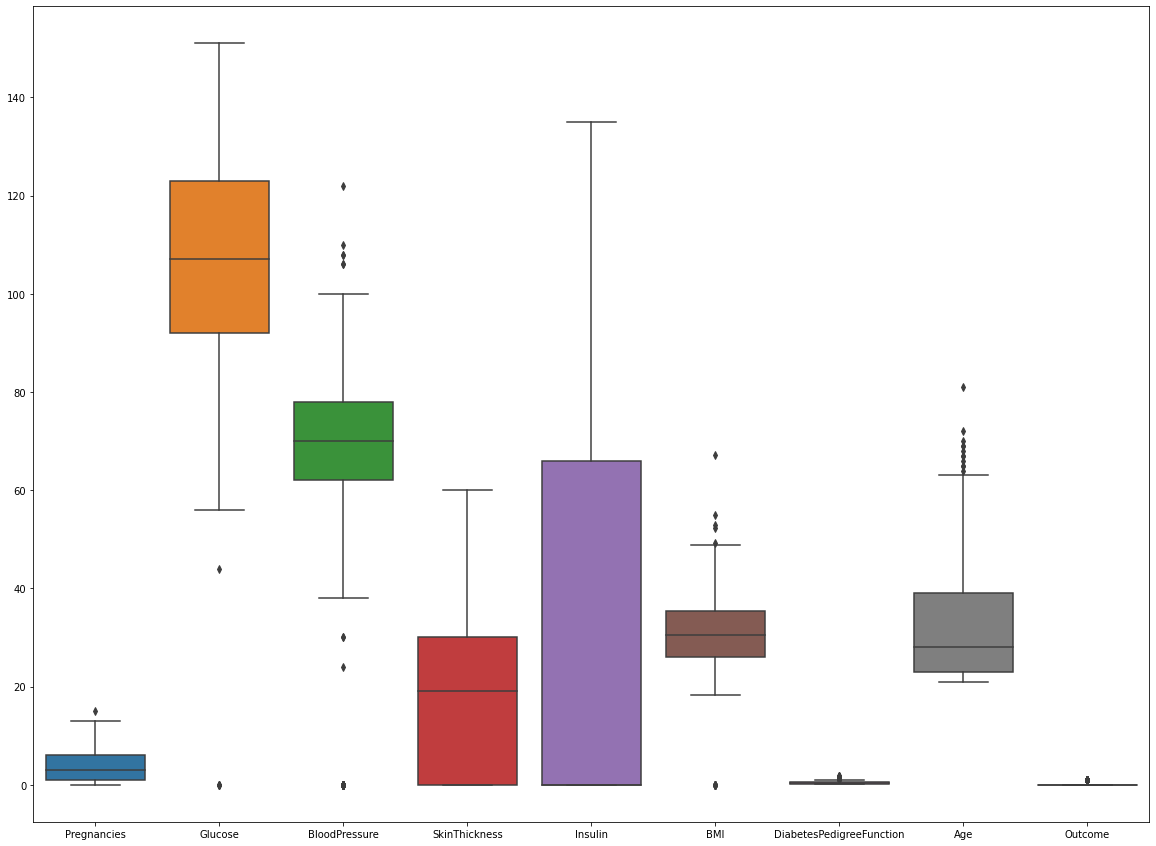

In [22]:
### Let's now check for the outliers

plt.figure(figsize=(20, 15))
sns.boxplot(data=df2)

### Staisfactorily dealing of Outliers!

In [23]:
### dataeset to go ahead with 

df2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72,35,0.0,33.6,0.627,50,1
1,1,85.0,66,29,0.0,26.6,0.351,31,0
3,1,89.0,66,23,94.0,28.1,0.167,21,0
5,5,116.0,74,0,0.0,25.6,0.201,30,0
6,3,78.0,50,32,88.0,31.0,0.248,26,1


In [24]:
## features

X = df2.drop(columns=["Outcome"])
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72,35,0.0,33.6,0.627,50
1,1,85.0,66,29,0.0,26.6,0.351,31
3,1,89.0,66,23,94.0,28.1,0.167,21
5,5,116.0,74,0,0.0,25.6,0.201,30
6,3,78.0,50,32,88.0,31.0,0.248,26


In [25]:
## Label

Y = df2["Outcome"]
Y.head()

0    1
1    0
3    0
5    0
6    1
Name: Outcome, dtype: int64

In [26]:
### train test split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

In [27]:
x_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
381,0,105.0,68,22,0.0,20.0,0.236,22
692,2,121.0,70,32,95.0,39.1,0.886,23
758,1,106.0,76,0,0.0,37.5,0.197,26
239,0,104.0,76,0,0.0,18.4,0.582,27
64,7,114.0,66,0,0.0,32.8,0.258,42
...,...,...,...,...,...,...,...,...
627,0,132.0,78,0,0.0,32.4,0.393,21
200,0,113.0,80,16,0.0,31.0,0.874,21
193,11,135.0,0,0,0.0,52.3,0.578,40
737,8,65.0,72,23,0.0,32.0,0.600,42


In [33]:
### scaling the data to have mean=0 and s.d=1

scaler = StandardScaler()
scaler.fit(x_train, y_train)

StandardScaler()

In [40]:
## Standardized training features

x_train_scaled = scaler.transform(x_train)
x_train_scaled

array([[-1.1137263 , -0.11244171,  0.04768087, ..., -1.31037867,
        -0.67283476, -0.89422989],
       [-0.51085039,  0.59494207,  0.14515134, ...,  1.08797772,
         1.4916609 , -0.80765795],
       [-0.81228834, -0.06823023,  0.43756276, ...,  0.88706828,
        -0.8027045 , -0.54794212],
       ...,
       [ 2.20209124,  1.21390289, -3.2663152 , ...,  2.74548056,
         0.46602296,  0.66406507],
       [ 1.29777736, -1.88090118,  0.24262181, ...,  0.1964421 ,
         0.53928281,  0.83720895],
       [ 0.69490145,  0.41809613,  1.41226748, ..., -0.21793361,
        -0.93590423, -0.20165436]])

In [39]:
### Model building

mod = GaussianNB()
mod.fit(x_train_scaled, y_train)

GaussianNB()

In [41]:
## Accuracy on train data

mod.score(x_train_scaled, y_train)

0.7788461538461539

In [42]:
### Accuracy on test data

mod.score(scaler.transform(x_test), y_test)

0.7428571428571429

A little bit overfitting!

## # Should we have used PCA here? If yes, why and no then why not?

The first condition to implement **NaiveBayes** is that features have independent relation with the label without there being  any correlation within the features themselves.
<br><br>
What PCA does is it takes two or more features at a time and transform the axes retaining the meaning of the data. Now it is not necessary that the transformed axes will have the same independencies within themselves and dependencyy with label. So if we have used PCA here then the independency which is the base condition for Naive Bayes would have been lost, thus Naive Bayes would not have been the best pick here.